In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic 
import scipy
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

sns.set_style('whitegrid')

# Kings County Real Estate Predictions

The goal of this project is to use linear regression modeling to predict the price of houses sold in the greater Seattle, WA area.

In [2]:
data = pd.read_csv('../Phase-2-Project/Data/kc_house_data_train.csv')
data.drop(columns = 'Unnamed: 0', inplace = True)
data.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


## Exploratory Data Analysis

In [3]:
data.describe()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


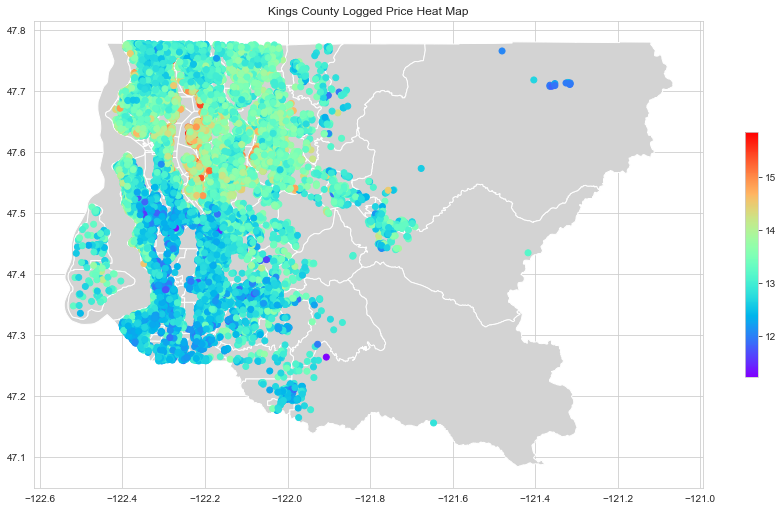

In [4]:
seatle_map = gpd.read_file('../Phase-2-Project/Data/kc_tract_10.shp')
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(data['long'], data['lat'])]
geo_df = gpd.GeoDataFrame(data, 
                          crs = crs, 
                          geometry = geometry)

geo_df['price_log'] = np.log(geo_df['price'])
fig, ax = plt.subplots(figsize = (15,15))
seatle_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'price_log', ax=ax, cmap = 'rainbow', legend = True, legend_kwds={'shrink': 0.3})

ax.set_title('Kings County Logged Price Heat Map')


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

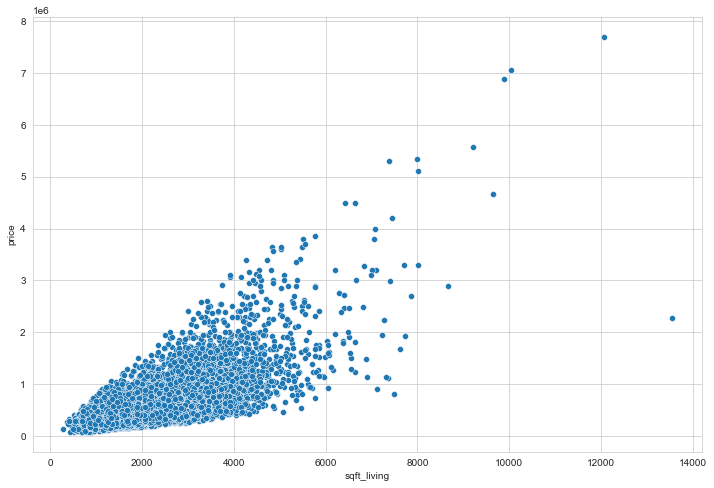

In [5]:
fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x = data.sqft_living, y = data.price)

Text(0.5, 1.0, 'Price x Year House Built')

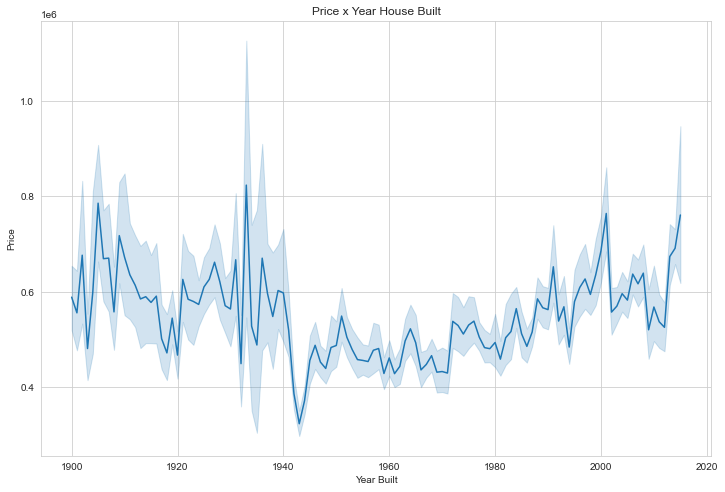

In [6]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = data['yr_built'], y = data['price'])
ax.set_xlabel('Year Built')
ax.set_ylabel('Price')
ax.set_title('Price x Year House Built')

Text(0.5, 1.0, 'Price x Zipcode')

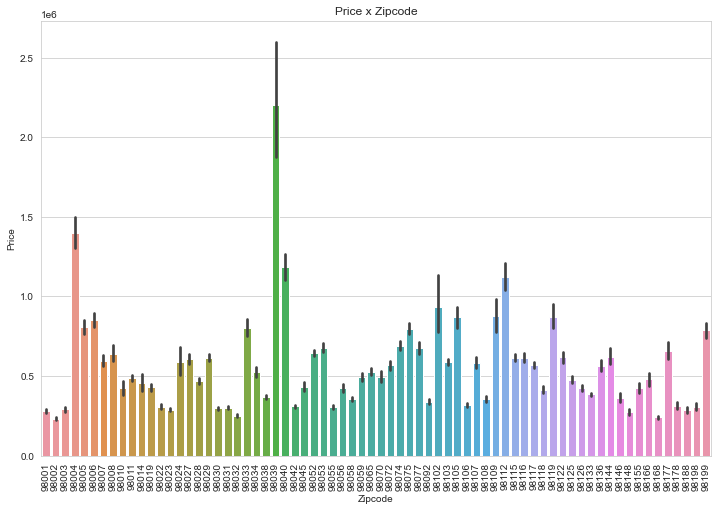

In [7]:
fig, ax = plt.subplots(figsize = (12,8))
zipcode_graph = sns.barplot(x = data.zipcode, y = data.price)
plt.xticks(rotation = 90)
ax.set_xlabel('Zipcode')
ax.set_ylabel('Price')
ax.set_title('Price x Zipcode')

Text(0.5, 1.0, 'Price x Grade')

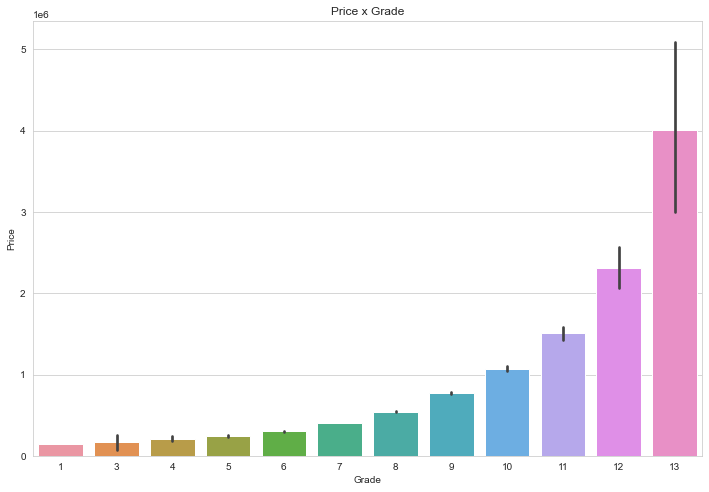

In [8]:
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(x = data.grade, y = data.price)
ax.set_xlabel('Grade')
ax.set_ylabel('Price')
ax.set_title('Price x Grade')


## Data Cleaning

There was no missing data in our dataset. Most data preperation focused on cleaning outliers and engineering additional features if needed. Below is how we dealt with outliers in the 'Sqft Living', 'Bedrooms' and 'Bathrooms' columns. 

Text(0.5, 1.0, 'Bathrooms')

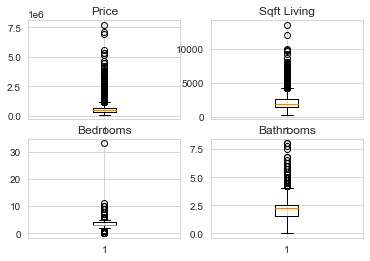

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].boxplot(data.price,)
axs[0, 0].set_title('Price')
axs[0, 1].boxplot(data.sqft_living)
axs[0, 1].set_title('Sqft Living')
axs[1, 0].boxplot(data.bedrooms,)
axs[1, 0].set_title('Bedrooms')
axs[1, 1].boxplot(data.bathrooms,)
axs[1, 1].set_title('Bathrooms')

Outliers in the data set were capped at 5 standard deviations away from the mean.

In [10]:
above_5std_living = data.sqft_living.mean()+(5*data.sqft_living.std())
above_5std_bathrooms = data.bathrooms.mean()+(5*data.bathrooms.std())
above_5std_bedrooms = data.bedrooms.mean()+(5*data.bedrooms.std())

data['sqft_living'] = np.where(data['sqft_living']>above_5std_living, above_5std_living, data['sqft_living'])
data['bathrooms'] = np.where(data['bathrooms']>above_5std_bathrooms, int(round((above_5std_bathrooms))), data['bathrooms'])
data['bedrooms'] = np.where(data['bedrooms']>above_5std_bedrooms, int(round((above_5std_bedrooms))), data['bedrooms'])
data['bathrooms'] = np.where(data['bathrooms']==0, .5, data['bathrooms'])
data['bedrooms'] = np.where(data['bedrooms']==0, .5, data['bedrooms'])

Text(0.5, 1.0, 'Bathrooms')

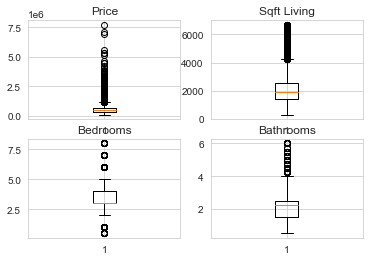

In [11]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].boxplot(data.price,)
axs[0, 0].set_title('Price')
axs[0, 1].boxplot(data.sqft_living,)
axs[0, 1].set_title('Sqft Living')
axs[1, 0].boxplot(data.bedrooms,)
axs[1, 0].set_title('Bedrooms')
axs[1, 1].boxplot(data.bathrooms,)
axs[1, 1].set_title('Bathrooms')

## Feature Engineering

Next, I began to look into what new features I can create out of the existing columsn. First I wanted to see how far the properties are located some some of Seattle's major businesses.

In [12]:
data['coordinates'] = list(zip(data.lat, data.long))

def distance_amazon(column):
    return(geodesic(column,(47.62246, -122.336775)).miles)
def distance_tmobile(column):
    return(geodesic(column,(47.57879, -122.16547)).miles)
def distance_sb(column):
    return(geodesic(column,(47.581002000, -122.335898000)).miles)

data['dist_sb'] = data['coordinates'].map(distance_sb)
data['dist_tmobile'] = data['coordinates'].map(distance_tmobile)
data['dist_amazon'] = data['coordinates'].map(distance_amazon)

Text(0.5, 1.0, 'Correlation Price x Distance from Major Business')

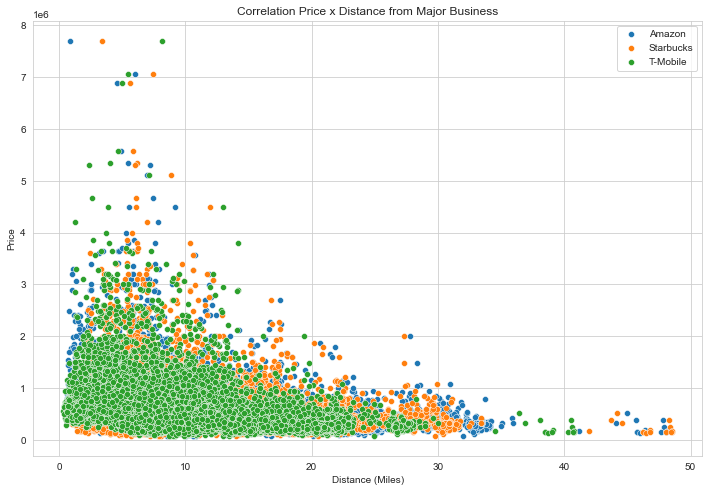

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x = data.dist_amazon, y = data.price, label = 'Amazon')
sns.scatterplot(x = data.dist_sb, y = data.price, label ='Starbucks')
sns.scatterplot(x = data.dist_tmobile, y = data.price, label = 'T-Mobile')
plt.legend()
ax.set_xlabel('Distance (Miles)')
ax.set_ylabel('Price')
ax.set_title('Correlation Price x Distance from Major Business')


I wanted to see if houses that had more bathrooms than bedrooms indicate a higher sales price. Per the graph below you can see price does spike after once the ratio is higher than 1.

<AxesSubplot:xlabel='bath_bed_ratio', ylabel='price'>

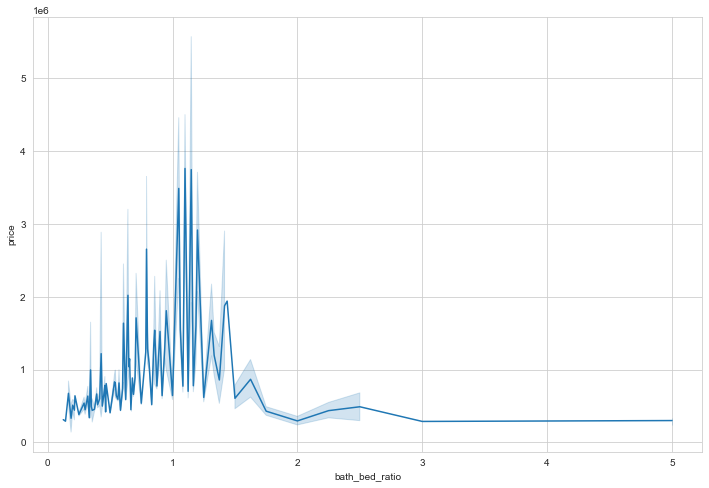

In [14]:
data['bath_bed_ratio'] = data.bathrooms/data.bedrooms

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = data.bath_bed_ratio, y = data.price)

The age of a house does seem to affect the price. Older/more historic houses and recently built homes seem to correlate to higher sales proces on average.

Text(0.5, 1.0, 'Price x Age of House')

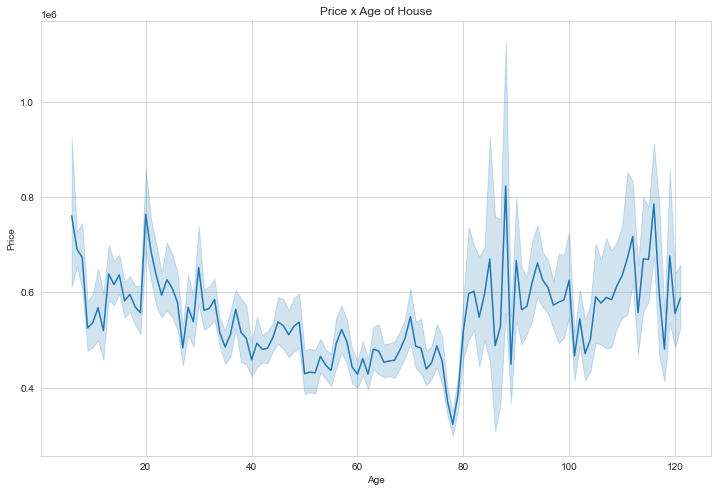

In [15]:
data['age'] = 2021 - data['yr_built']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = data['age'], y = data['price'])
ax.set_xlabel('Age')
ax.set_ylabel('Price')
ax.set_title('Price x Age of House')


## Statiscal Testing

All tests had alpha = .05; 95% confidence

Null Hypothesis: There is no difference in average price of house north of 47.5 latitude compared to those south of 47.5.

Alternative Hypothesis: There is a difference in average prices.

In [16]:
north = data[data['lat'] > 47.5].price
south = data[data['lat'] <= 47.5].price

scipy.stats.ttest_ind(north,south, nan_policy = 'omit')

Ttest_indResult(statistic=52.39492100842781, pvalue=0.0)

We reject the null hypothesis

Null Hypothesis: There is no difference in average price of houses with waterviews vs without.

Alternative Hypothesis: There is a difference in average prices.

<AxesSubplot:xlabel='waterfront', ylabel='price'>

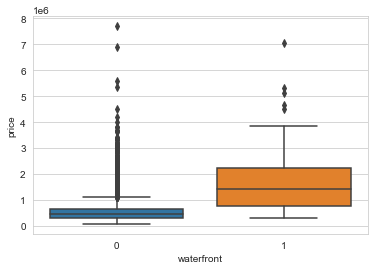

In [17]:
sns.boxplot(x = data['waterfront'], y = data['price'])

In [18]:
waterview = data[data.waterfront == 1].price
non_waterview = data[data.waterfront == 0].price

scipy.stats.ttest_ind(waterview,non_waterview, nan_policy = 'omit')

Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

We reject the null hypothesis

Null Hypothesis: There is no difference in average price of houses with different grades.

Alternative Hypothesis: There is a difference in average prices.

<AxesSubplot:xlabel='grade', ylabel='price'>

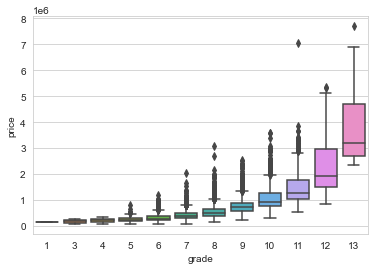

In [19]:
sns.boxplot(x = data.grade, y = data.price)

In [20]:
r13 = data[data.grade == 13].price
r12 = data[data.grade == 12].price
r11 = data[data.grade == 11].price
r10 = data[data.grade == 10].price
r9 = data[data.grade == 9].price
r8 = data[data.grade == 8].price
r7 = data[data.grade == 7].price
r6 = data[data.grade == 6].price
r5 = data[data.grade == 5].price
r4 = data[data.grade == 4].price
r3 = data[data.grade == 3].price
r1 = data[data.grade == 1].price

anova_grade = scipy.stats.f_oneway(r1,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13)
anova_grade

F_onewayResult(statistic=1763.5110290471393, pvalue=0.0)

We reject the null hypothesis.

Null Hypothesis: There is no difference in average price of houses in different conditions
Alternative Hypothesis: There is a difference in average prices.

<AxesSubplot:xlabel='condition', ylabel='price'>

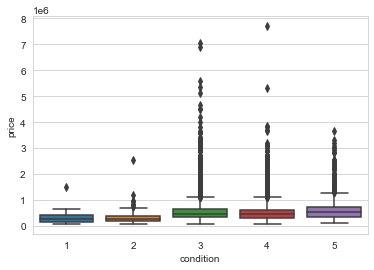

In [21]:
sns.boxplot(x = data.condition, y = data.price)

In [22]:
con1 = data[data.condition == 1].price
con2 = data[data.condition == 2].price
con3 = data[data.condition == 3].price
con4 = data[data.condition == 4].price
con5 = data[data.condition == 5].price

anova_cond = scipy.stats.f_oneway(con1, con2, con3, con4, con5)
anova_cond

F_onewayResult(statistic=28.799197350706148, pvalue=6.813536869427384e-24)

We reject the null hypothesis.

## Feature Selection

The correlation heatmap below show all of the features from the provided data and new features have just engineered correlated against one another. It is a good idea to assess whether any features correlate to highly with one another as this can lead to multicolinearity in our model. We won't be including this many features in our model, but its a good suggestion to drop anything over .90.

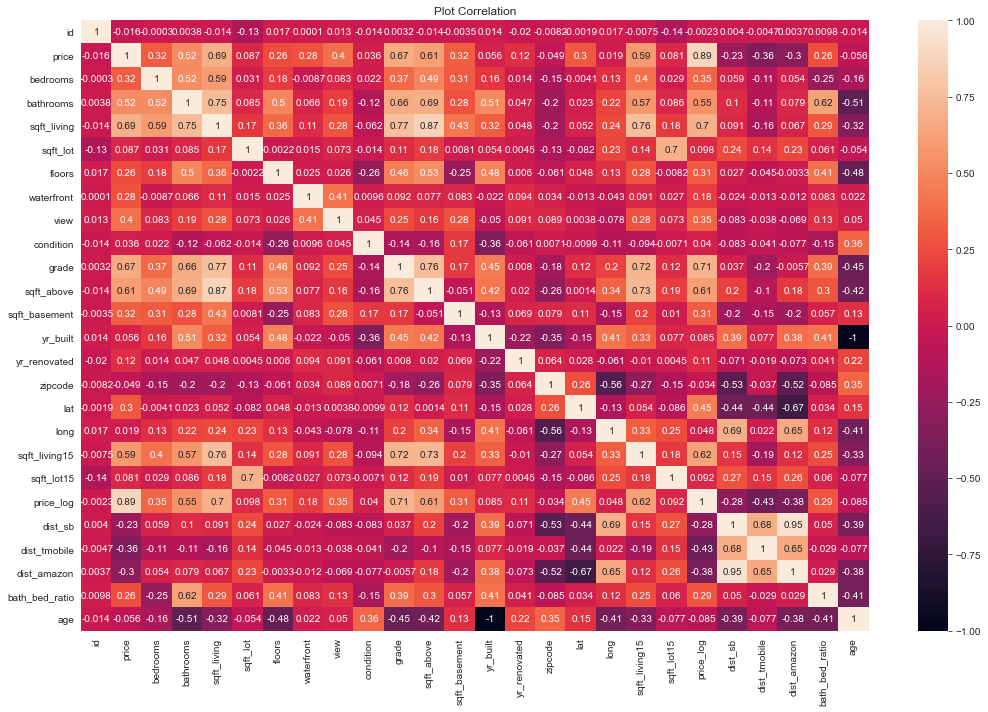

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.title('Plot Correlation')
plt.tight_layout()
plt.show()

Now we are ready for our first model. The OLS model below shows how well 'sqft_living', 'zipcode', 'grade', 'dist_amazon', 'dist_tmobile' & 'bathrooms' explain the variation of the mean of our target price. You can see that it does a pretty good job with an r-squared value of 0.819. 'Sqft_living', for example, helps to explain the variance as noted by it's 0.000 p-value and if all else held constant, 1 more sq_ft lving would amount to roughly $155.

In [24]:
lr_model2 = ols(formula='price~sqft_living+C(zipcode)+C(grade)+dist_amazon+dist_tmobile+waterfront+C(bathrooms)', data=data).fit()

lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     734.7
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:50:15   Log-Likelihood:            -2.3158e+05
No. Observations:               17290   AIC:                         4.634e+05
Df Residuals:                   17183   BIC:                         4.642e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.382e+05   1.62e+05      0.853      0.394    -1.8e+05    4.56e+05
C(zipcode)[T.98002]   1.985e+04    1.6e+04      1.241      0.215   -1.15e+04    5.12e+04
C(zipcode)[T.98003]   -1.57e+04   1.43e+04     -1.097      0.273   -4.37e+04    1.23e+04
C(zipcode)[T.98004]   6.512e+05   2.06e+04     31.556      0.000    6.11e+05    6.92e+05
C(zipcode)[T.98005]   2.024e+05   2.31e+04      8.782      0.000    1.57e+05    2.48e+05
C(zipcode)[T.98006]   1.963e+05   2.15e+04      9.143      0.000    1.54e+05    2.38e+05
C(zipcode)[T.98007]   1.634e+05   2.37e+04      6.901      0.000    1.17e+05     2.1e+05
C(zipcode)[T.98008]   2.045e+05   2.11e+04      9.668      0.000    1.63e+05    2.46e+05
C(zipcode)[T.98010]   1.306e+05   2.21e+04      5.910      0.000    8.73e+04    1.74e+05
C(zipcode)[T.98011]   1.383e+04   1.88e+04      0.737      0.461   -2.29e+04    5.06e+04
C(zipcode)[T.98014]   1.465e+05      2e+04      7.317      0.000    1.07e+05    1.86e+05
C(zipcode)[T.98019]   8.118e+04   1.71e+04      4.742      0.000    4.76e+04    1.15e+05
C(zipcode)[T.98022]   1.611e+05   1.81e+04      8.887      0.000    1.26e+05    1.97e+05
C(zipcode)[T.98023]  -4.372e+04   1.27e+04     -3.433      0.001   -6.87e+04   -1.88e+04
C(zipcode)[T.98024]   2.092e+05   2.48e+04      8.439      0.000    1.61e+05    2.58e+05
C(zipcode)[T.98027]   1.384e+05   1.91e+04      7.247      0.000    1.01e+05    1.76e+05
C(zipcode)[T.98028]  -3000.2602   1.88e+04     -0.159      0.873   -3.99e+04    3.39e+04
C(zipcode)[T.98029]   1.906e+05   1.96e+04      9.702      0.000    1.52e+05    2.29e+05
C(zipcode)[T.98030]  -1.773e+04   1.55e+04     -1.146      0.252   -4.81e+04    1.26e+04
C(zipcode)[T.98031]  -2.086e+04    1.6e+04     -1.303      0.193   -5.22e+04    1.05e+04
C(zipcode)[T.98032]  -3.719e+04   1.88e+04     -1.980      0.048    -7.4e+04    -377.827
C(zipcode)[T.98033]   2.268e+05   1.78e+04     12.764      0.000    1.92e+05    2.62e+05
C(zipcode)[T.98034]   6.673e+04   1.69e+04      3.948      0.000    3.36e+04    9.99e+04
C(zipcode)[T.98038]   6.774e+04   1.44e+04      4.714      0.000    3.96e+04    9.59e+04
C(zipcode)[T.98039]   1.033e+06   3.09e+04     33.471      0.000    9.73e+05    1.09e+06
C(zipcode)[T.98040]    3.85e+05   2.07e+04     18.639      0.000    3.45e+05    4.25e+05
C(zipcode)[T.98042]   2.299e+04   1.37e+04      1.678      0.093   -3871.552    4.99e+04
C(zipcode)[T.98045]    2.03e+05   1.89e+04     10.762      0.000    1.66e+05     2.4e+05
C(zipcode)[T.98052]   1.425e+05   1.63e+04      8.748      0.000    1.11e+05    1.74e+05
C(zipcode)[T.98053]   1.686e+05   1.61e+04     10.475      0.000    1.37e+05       2e+05
C(zipcode)[T.98055]  -2.774e+04   1.77e+04     -1.568      0.117   -6.24e+04    6931.879
C(zipcode)[T.98056]   1.836e+04   1.89e+04      0.973    

Instead of creating a model with all of our columns, I am subsetting our data set with just the columns I believe are best needed to predict housing prices. I am first dropping all columns that too highly correlate with one another such as 'dist_amazon' & 'dist_sb' and 'sqft_living_above' as it is too similar to 'sqft_living.' Further more, I will be 'dummying' our categorical data so that it can be better interpreted in our model.

In [25]:
model_df = data[['price','sqft_living', 'dist_amazon','dist_tmobile', 'grade', 'waterfront', 'condition', 'zipcode','bathrooms']]

In [26]:
model_df.corr()

,price,sqft_living,dist_amazon,dist_tmobile,grade,waterfront,condition,zipcode,bathrooms
price,1.000000,0.688506,-0.298337,-0.355573,0.666215,0.275779,0.036099,-0.048958,0.520116
sqft_living,0.688506,1.000000,0.067295,-0.161180,0.766514,0.105652,-0.061863,-0.198351,0.754757
dist_amazon,-0.298337,0.067295,1.000000,0.651752,-0.005687,-0.011844,-0.076860,-0.518328,0.079148
dist_tmobile,-0.355573,-0.161180,0.651752,1.000000,-0.195444,-0.013419,-0.040869,-0.037436,-0.109462
grade,0.666215,0.766514,-0.005687,-0.195444,1.000000,0.092234,-0.142066,-0.184946,0.664935
waterfront,0.275779,0.105652,-0.011844,-0.013419,0.092234,1.000000,0.009608,0.034282,0.065592
condition,0.036099,-0.061863,-0.076860,-0.040869,-0.142066,0.009608,1.000000,0.007068,-0.123630
zipcode,-0.048958,-0.198351,-0.518328,-0.037436,-0.184946,0.034282,0.007068,1.000000,-0.202736
bathrooms,0.520116,0.754757,0.079148,-0.109462,0.664935,0.065592,-0.123630,-0.202736,1.000000


In [27]:
dummy_df = pd.get_dummies(model_df, columns = ['grade', 'condition', 'zipcode', 'bathrooms'], drop_first = True)
dummy_df.head()

,price,sqft_living,dist_amazon,dist_tmobile,waterfront,grade_3,grade_4,grade_5,grade_6,grade_7,...,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0
0,365000.0,2070.0,15.095046,9.672506,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,865000.0,2900.0,4.558244,8.861090,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1038000.0,3770.0,10.500562,1.966793,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1490000.0,4560.0,7.355444,8.835713,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,711000.0,2550.0,12.202455,7.075604,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = dummy_df.drop(columns = 'price')
y = dummy_df.price

reg = LinearRegression()
lm = reg.fit(X,y)

print(lm.intercept_)
print(lm.coef_)
lm.score(X, y)


135917.76662119484
[ 1.50732532e+02 -1.54456432e+04  6.53776860e+03  8.19755808e+05
 -2.47339124e+04 -4.33794208e+04 -1.06439443e+05 -1.14125373e+05
 -1.03006954e+05 -6.13095146e+04  3.26620598e+04  1.69161774e+05
  3.68573498e+05  7.92622802e+05  2.08195606e+06  8.97188994e+04
  9.49871261e+04  1.25543951e+05  1.77472897e+05  8.94139198e+03
 -1.73229658e+04  6.45270916e+05  1.90988741e+05  1.84735767e+05
  1.56082405e+05  1.97806222e+05  1.26264977e+05  1.77406579e+04
  1.53515099e+05  9.07669876e+04  1.49049704e+05 -4.64970553e+04
  2.13285747e+05  1.37756027e+05 -3.66737325e+03  1.93860575e+05
 -1.59956607e+04 -2.55716465e+04 -4.36049063e+04  2.21009446e+05
  6.53044701e+04  7.14612703e+04  1.02260510e+06  3.69223086e+05
  1.69466646e+04  2.08900546e+05  1.42560781e+05  1.77455445e+05
 -2.61511642e+04  6.10246683e+03 -7.71959178e+03  2.64428176e+04
  1.61971691e+05 -5.43290046e+04  7.24453676e+04  1.32868253e+05
  1.46390395e+05  5.31369452e+04  6.15857001e+03  2.33283392e+05
  1.07

0.8229835024639129

In [29]:
y_pred = lm.predict(X)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(mae)
print(rmse)

91877.34555172891
157063.1782517489


In [30]:
data['price'].std()

373318.9787492793

Running this through our linear regression model we get an RMSE of ~$157K which does look good compared to our price's standard deviation, but can we get our RMSE even lower using some more advanced feature selection?

/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predictions')

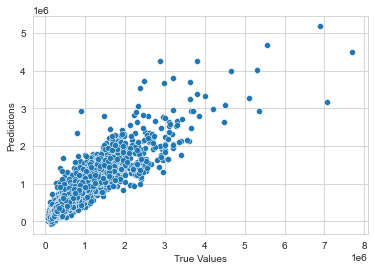

In [31]:
sns.scatterplot(dummy_df['price'], y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='price'>

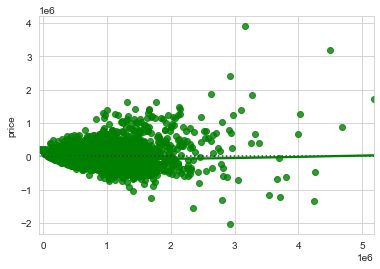

In [32]:
sns.residplot(y_pred, dummy_df['price'], lowess=True, color="g")

Plotting our errors above shows that while they are evenly distributed, we are missing on a few outliers.

## Original Model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9,test_size=0.2)

In [34]:
#instantiate a linear regression object
test_lm = LinearRegression()

#fit the linear regression to the data
test_lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 158715.18895093375


In [35]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 151964.61797635633
Training:  158715 vs. Testing:  151964


## Polynomial Model

In [36]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X)
poly2_columns = poly_2.get_feature_names(X.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,sqft_living,dist_amazon,dist_tmobile,waterfront,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,...,bathrooms_5.25^2,bathrooms_5.25 bathrooms_5.5,bathrooms_5.25 bathrooms_5.75,bathrooms_5.25 bathrooms_6.0,bathrooms_5.5^2,bathrooms_5.5 bathrooms_5.75,bathrooms_5.5 bathrooms_6.0,bathrooms_5.75^2,bathrooms_5.75 bathrooms_6.0,bathrooms_6.0^2
0,2070.0,15.095046,9.672506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2900.0,4.558244,8.861090,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3770.0,10.500562,1.966793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4560.0,7.355444,8.835713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2550.0,12.202455,7.075604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_poly2, y, random_state=9,test_size=0.2)

In [38]:
test_lm_2 = LinearRegression()

#fit the linear regression to the data
test_lm_2 = test_lm_2.fit(X_train2, y_train2)

y_train_pred2 = test_lm_2.predict(X_train2)

train_rmse2 = np.sqrt(metrics.mean_squared_error(y_train2, y_train_pred2))


print('Training Root Mean Squared Error:' , train_rmse2)

Training Root Mean Squared Error: 93009.95611082966


In [39]:
y_pred2 = test_lm_2.predict(X_test2)

test_rmse2 = np.sqrt(metrics.mean_squared_error(y_test2, y_pred2))

print('Testing Root Mean Squared Error:' , test_rmse2)


print('Training: ', int(train_rmse2), "vs. Testing: ", int(test_rmse2))

Testing Root Mean Squared Error: 183223.75184691948
Training:  93009 vs. Testing:  183223


## Applying 'Select K Best' to Polynomial Model

In [40]:
selector = SelectKBest(f_regression, k=100)

selector.fit(X_train2, y_train2)

/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/ryanlewis/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=100, score_func=<function f_regression at 0x7fc8a4c83d30>)

In [41]:
selected_columns = X_train2.columns[selector.get_support()]
removed_columns = X_train2.columns[~selector.get_support()]

In [42]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest.fit(X_train2[selected_columns], y_train2)

y_train_kbest = lm_kbest.predict(X_train2[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test2[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test2, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 144834.9811074046
Testing Root Mean Squared Error: 149626.31351299002


## Log Price Model

In [43]:

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, random_state = 15, test_size=0.2)
    
y_log = np.log(y_train_log)
    #instantiate a linear regression object
lm_log = LinearRegression()
    #fit the linear regression to the data
lm_log = lm_log.fit(X_train_log, y_log)
log_train_pred  = lm_log.predict(X_train_log)
    #log_train_pred the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
    
    #use fitted model to predict on the test examples
    
log_test_pred = lm_log.predict(X_test_log)
    #get test predictions back to original scale
y_test_pred = np.exp(log_test_pred)
    
    #evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred))
    
print({'train_rmse': train_rmse, 'test_rmse' : test_rmse})

{'train_rmse': 143837.0932681768, 'test_rmse': 133294.58877563672}


## Final Model Decision

After comparing all of our models, I decided to move forward with the SKB Polynomial Model. Other than the logged price model, it had the lowest test RMSE score at 149,926 and the lowest % difference in training vs testing RMSE showing that it is the least overfit of our models. Our final r^2 value = 0.847, showing that it does a strong job explaining the variation around the mean of our target.

When predicting prices on the new holdout data set, the logged model gave estimates further away from the sample mean than our SKB model - ultimately leading me to choose the SKB model as our final model despite it having a higher RMSE.

In [55]:
lm_kbest.score(df_poly2[selected_columns], data['price'])

0.8474490758232915

In [65]:
lm_log.score(X, np.log(y))

0.866151520541136

SKB Model Pickle

In [46]:
lm_final_SKB = LinearRegression()
lm_final_SKB = lm_final_SKB.fit(df_poly2[selected_columns], data['price'])


In [66]:
lm_final_log = LinearRegression()
lm_final_log = lm_final_log.fit(X, np.log(y))

In [49]:
import pickle


pickle_out = open("model.pickle","wb")
pickle.dump(lm_final_SKB, pickle_out)
pickle_out.close()

In [67]:
import pickle


pickle_out = open("model2.pickle","wb")
pickle.dump(lm_final_log, pickle_out)
pickle_out.close()

In [50]:
other_info = [above_5std_living, above_5std_bathrooms, above_5std_bedrooms, selected_columns]